In [43]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime, timedelta, timezone
from bs4 import BeautifulSoup


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu pct_change

In [ ]:
def get_vn30f(symbol, resolution, start_time=None, now_time=None):
    if start_time:
      start_time = datetime.strptime(start_time, '%Y-%m-%d')
      start_time = int((start_time - timedelta(hours=7)).timestamp())
    else:
        start_time = 0

    if now_time:
      now_time = datetime.strptime(now_time, '%Y-%m-%d')
      now_time = int((now_time - timedelta(hours=7)).timestamp())
    else:
      now_time = 9999999999

    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution={resolution}&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

start_time = 0
now_time = '2024-10-24'
symbol = 'VN30F1M'
df_min = get_vn30f(symbol=symbol, resolution='1', start_time=None, now_time=now_time)

In [95]:
pct_change = pd.DataFrame(df_min[['Date','Close']])

In [125]:
time = [1,3,5,10,15,30,60]
for i in time:
    # Tính phần trăm thay đổi và dịch giá trị
    changes = pct_change['Close'].pct_change(i).shift(-i).ffill()

    # Tính ngưỡng phần trăm 25% và 75%
    lower_bound = np.percentile(changes.dropna(), 25)
    upper_bound = np.percentile(changes.dropna(), 75)
    
    # Tạo cột mới với điều kiện
    pct_change[f'{i}'] = np.where(
        changes > upper_bound, 1,
        np.where(changes < lower_bound, -1, 0)
    )


In [126]:
pct_change

,Date,Close,1,3,5,10,15,30,60
0,2018-08-13 09:00:00,942.9,0,1,0,0,0,1,1
1,2018-08-13 09:01:00,943.1,1,0,0,0,0,0,1
2,2018-08-13 09:02:00,943.5,0,-1,0,-1,0,0,0
3,2018-08-13 09:03:00,943.4,-1,0,0,0,-1,0,0
4,2018-08-13 09:04:00,943.1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
344584,2024-10-23 14:27:00,1352.7,-1,0,1,0,1,1,0
344585,2024-10-23 14:28:00,1352.2,1,1,1,0,1,1,0
344586,2024-10-23 14:29:00,1353.2,-1,1,1,0,1,1,0
344587,2024-10-23 14:30:00,1352.6,1,1,1,0,1,1,0


# Chuẩn bị dữ liệu text

## Lấy thời gian cho dữ liệu và chia khung thời gian

In [ ]:
df_link = pd.read_csv('articles_data.csv')

In [66]:
date = pd.DataFrame(df_link['Link'][0:1000])

In [67]:
for index, link in enumerate(date['Link']):
    try:
        response = requests.get(link)
        if response.status_code == 200:
            article_soup = BeautifulSoup(response.content, 'html.parser')

            # Tìm thẻ <span> chứa ngày tháng
            date_tag = article_soup.find('span', class_='pdate', attrs={'data-role': 'publishdate'})
            
            # Kiểm tra và gán giá trị ngày tháng vào cột Date
            if date_tag:
                date.at[index, 'Date'] = date_tag.get_text().strip()
            else:
                print(f"Không tìm thấy ngày tháng trong bài viết: {link}")
        else:
            print(f"Lỗi khi truy cập link: {link} - Mã trạng thái HTTP: {response.status_code}")

    except Exception as e:
        print(f"Lỗi khi xử lý bài viết {link}: {e}")

# Hiển thị kết quả
print(date)

Không tìm thấy ngày tháng trong bài viết: https://cafef.vn/nu-tuong-vinacapital-va-khat-vong-tro-ve-que-huong-phat-trien-thi-truong-tai-chinh-viet-nam-xuyen-suot-2-thap-ky-188241022193609141.chn
Không tìm thấy ngày tháng trong bài viết: https://cafef.vn/ong-la-giang-trung-lam-nghe-chung-khoan-co-bien-dong-nhip-tim-cao-nhieu-ban-be-cua-toi-gia-di-trong-thay-188241015174142845.chn
Không tìm thấy ngày tháng trong bài viết: https://cafef.vn/chu-tich-ree-nguyen-thi-mai-thanh-dung-qua-nghi-ve-kpi-roi-ha-tieu-chuan-de-dau-tu-cho-duoc-188241001122154896.chn
Không tìm thấy ngày tháng trong bài viết: https://cafef.vn/techcom-securities-cau-chuyen-wealthtech-va-hanh-trinh-dan-dat-so-hoa-188240918190325368.chn
Không tìm thấy ngày tháng trong bài viết: https://cafef.vn/chu-tich-dragon-capital-toi-thay-phan-lon-kho-khan-cua-thi-truong-da-o-sau-lung-188240910202602297.chn
                                                  Link                   Date
0    https://cafef.vn/dieu-it-biet-ve-san-tmdt-temu.

In [69]:
date['Date'] = date['Date'].str.replace(r'\s*AM\s*|\s*PM\s*', '', regex=True).str.strip()
date['Date'] = pd.to_datetime(date['Date'], format='%d-%m-%Y - %H:%M')

In [71]:
date = date.ffill()

In [72]:
date['Time_Group'] = date['Date'].apply(
    lambda x: 1 if x.time() >= pd.Timestamp("07:30").time() and x.time() <= pd.Timestamp("14:30").time() else 0
)
date

,Link,Date,Time_Group
0,https://cafef.vn/dieu-it-biet-ve-san-tmdt-temu...,2024-10-24 00:05:00,0
1,https://cafef.vn/margin-cao-ky-luc-nhung-thanh...,2024-10-24 00:02:00,0
2,https://cafef.vn/tu-doanh-ctck-tro-lai-mua-ron...,2024-10-24 17:38:00,0
3,https://cafef.vn/ty-phu-nguyen-dang-quang-chi-...,2024-10-24 17:32:00,0
4,https://cafef.vn/chuoi-sieu-thi-cua-ti-phu-ngu...,2024-10-24 16:52:00,0
...,...,...,...
995,https://cafef.vn/mot-ma-chung-khoan-bat-ngo-bi...,2024-09-05 16:41:00,0
996,https://cafef.vn/trong-6-thang-dau-nam-2024-li...,2024-09-05 16:01:00,0
997,https://cafef.vn/soi-luong-lanh-dao-200-doanh-...,2024-09-05 15:54:00,0
998,https://cafef.vn/cong-ty-cua-ty-phu-pham-nhat-...,2024-09-05 15:44:00,0


## Kết hợp dữ liệu text

In [ ]:
df_sentiment = pd.read_csv('1000.csv')

In [76]:
df_sentiment['Date'] = date['Date']
df_sentiment['Time_Group'] = date['Time_Group']

In [77]:
df_sentiment

,Text,price movement,Date,Time_Group
0,Điều ít biết về sàn TMĐT Temu đang gây bão vì ...,0.0,2024-10-24 00:05:00,0
1,Margin cao kỷ lục nhưng thanh khoản thị trường...,-1.0,2024-10-24 00:02:00,0
2,Tự doanh CTCK trở lại mua ròng trong phiên 24/...,0.0,2024-10-24 17:38:00,0
3,Tỷ phú Nguyễn Đăng Quang chỉ nắm 18 cổ phiếu M...,0.0,2024-10-24 17:32:00,0
4,Chuỗi siêu thị của tỉ phú Nguyễn Đăng Quang bắ...,0.0,2024-10-24 16:52:00,0
...,...,...,...,...
995,"HoSE tiếp tục cắt margin cổ phiếu do thua lỗ, ...",-1.0,2024-09-05 16:41:00,0
996,Biến động nhân sự cấp cao tại Đầu tư Hải Phát ...,0.0,2024-09-05 16:01:00,0
997,“The Investors”: Chuỗi Talkshow truyền cảm hứn...,0.0,2024-09-05 15:54:00,0
998,"Hé lộ thu nhập ""khủng"" của chủ tịch, tổng giám...",0.0,2024-09-05 15:44:00,0


In [127]:
merged_df = pd.merge(df_sentiment, pct_change, on='Date', how='inner')

# Chọn các cột cần thiết cho DataFrame mới
final_df = merged_df[['Date', 'Text', 'price movement', '1', '3', '5', '10', '15', '30', '60']]

In [128]:
final_df

,Date,Text,price movement,1,3,5,10,15,30,60
0,2024-10-23 13:34:00,"Lợi nhuận công ty bán vàng mã xuống đáy 4 năm,...",0.0,0,0,1,1,1,0,0
1,2024-10-23 13:31:00,Ngày đầu thương vụ lớn nhất lịch sử chứng khoá...,0.0,-1,-1,0,0,0,0,0
2,2024-10-23 10:55:00,"Nhựa Bình Minh (BMP) chuẩn bị trả cổ tức ""khủn...",0.0,1,0,1,1,1,1,1
3,2024-10-23 10:11:00,Báo nước ngoài bất ngờ trước sức hút của mã cổ...,0.0,0,0,0,-1,-1,-1,0
4,2024-10-23 10:00:00,"Nhựa Việt Thành mở rộng hệ sinh thái, phân phố...",0.0,0,0,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...
249,2024-09-06 14:06:00,Cổ đông Vinhomes tán thành việc mua lại 370 tr...,1.0,0,0,-1,0,0,-1,-1
250,2024-09-06 14:04:00,Chứng khoán KIS trao thưởng gần 1 tỷ đồng với ...,0.0,-1,-1,0,0,0,-1,-1
251,2024-09-06 13:37:00,Việc làm ăn của doanh nhân từng ngồi 'ghế nóng...,0.0,1,1,1,0,0,0,-1
252,2024-09-06 11:01:00,Nữ tổng giám đốc lương cao nhất Việt Nam là ai...,0.0,0,0,-1,0,0,0,0


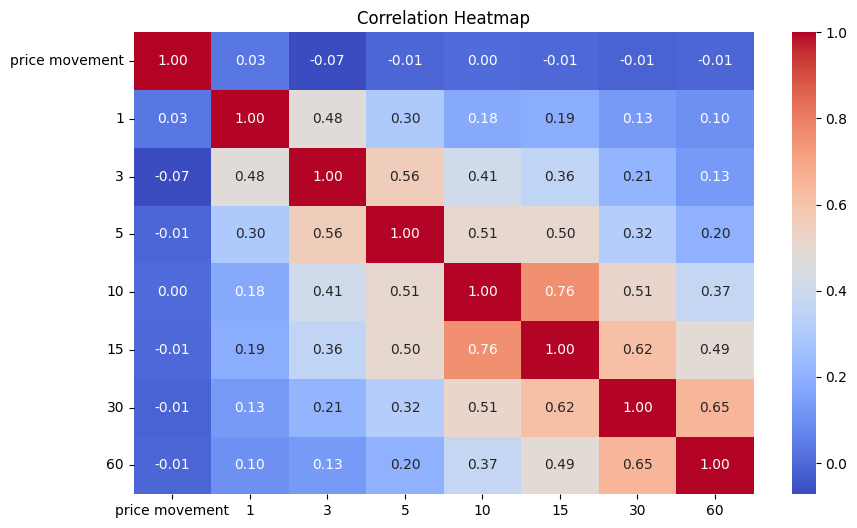

In [132]:
correlation_matrix = final_df[['price movement', '1', '3', '5', '10', '15', '30', '60']].corr()

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<Axes: >

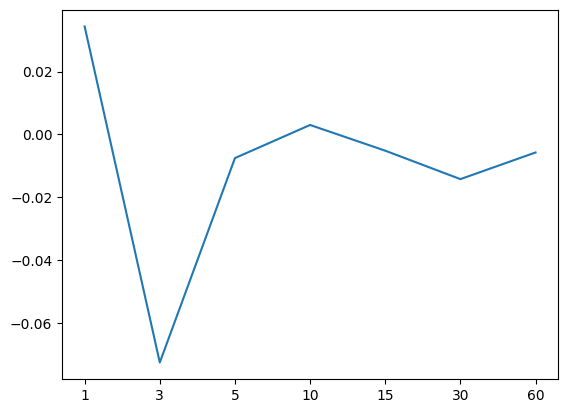

In [137]:
correlation_matrix['price movement'][1:].plot()

Kết luận, chatgpt đánh giá tuy hợp lý trên lý thuyết nhưng không hợp với thực tế